In [20]:
# import some helpful tools
import tools
import random
import copy

In [21]:
# Conways game of life?

In [22]:
# 1D Desription of microstructure evolution
# Show video?
# Discretize space into a series of cell
# Assign a state to each cell
# At every time step local a neeighbourhood is defined to each cell
# A state change rule is applied as a function of the neightbouring cells
# Simulation proceeds in a series of discrete time steps and computing the new states

In [23]:
liq = 0
solid = 1

In [24]:
size = 100
n_steps = 100
state_history = [] * n_steps
state = [liq] * size
temp_state = [liq] * size

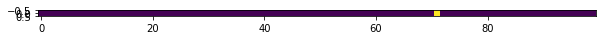

In [25]:
state[71] = solid
tools.display_state(state)

In [26]:
state_history.append(state)
for n in range(n_steps):
    for cell in range(len(state)):
        if sum(state[cell-1:cell+2]) > 0:
            temp_state[cell] = solid
    state = copy.deepcopy(temp_state)
    state_history.append(state)


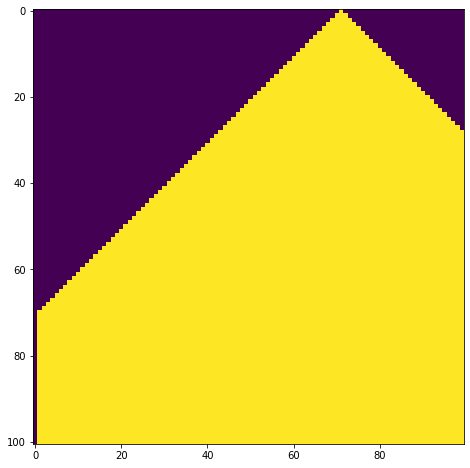

In [27]:
tools.display_growth(state_history)

In [28]:
import cv2
import numpy as np
import random
from math import exp

T = 2
l = 1
m0 = 1
Q = 1
k = 1

p_local = 0.2
p_max = 1
P = p_local / p_max

delta_t = round(T*l / (m0*p_max*exp(-Q/(k*T))))

nsteps = 250
state = np.zeros((nsteps, 1000))
temp = np.zeros((nsteps, 1000))

state[0, :] = np.random.random_sample(state.shape[1]) < 0.02
temp = state

for i in range(1, nsteps):
    for j in range(state.shape[1]):
        if state[i-1, j] == 1:
            temp[i, j] = 1
        elif random.uniform(0,1) < P and np.count_nonzero(state[i-1, j-1:j+2]):
            if i+delta_t >= temp.shape[0]:
                temp[temp.shape[0]-1, j] = 1
            else:
                temp[i+delta_t, j] = 1
        else:
            pass
    state[i] = temp[i]

    cv2.imshow("", state)
    cv2.waitKey(100)
cv2.destroyAllWindows()

In [30]:

import cv2
import numpy as np
import copy

nc_x = nc_y = 100
nc = nc_x * nc_y

unrec = 0
rec = 1

# neighborhood = "von Neumann"
neighborhood = "Moore"

state = np.random.random_sample((nc_x,nc_y)) < 0.001
state = state.astype('uint8')


while np.all(state) == False:

    temp = copy.deepcopy(state)

    cv2.imshow("", state*255)
    cv2.waitKey(100)

    for x in range(state.shape[1]):
        for y in range(state.shape[0]):

            if state[y,x] == rec:
                if neighborhood == "Moore":
                    temp[y-1:y+2, x-1:x+2] = rec

                if neighborhood == "von Neumann":
                    temp[y-1:y+2, x] = rec
                    temp[y, x-1:x+2] = rec


    state = copy.deepcopy(temp)

cv2.destroyAllWindows()
